# Gender Bias in Sentiment Analysis
Aaricia Herygers, Christian Schneider, Zeqian Wang

Data Science Bootcamp @ DataScientest

## Requirements

In [1]:
pip install nltk scikit-learn germansentiment

Note: you may need to restart the kernel to use updated packages.


## Imports and Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk #For stopwords and tokenization #1
import torch

from nltk.stem import SnowballStemmer #For Stemming in English and German
from nltk.sentiment.vader import SentimentIntensityAnalyzer #For English Sentiment #1

from germansentiment import SentimentModel #For German Sentiment #1

from transformers import AutoTokenizer, AutoModelForSequenceClassification #For tokenization and sentiment #2
import torch

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.utils import to_categorical

from tensorflow.keras.callbacks import ReduceLROnPlateau


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
2024-03-10 21:59:01.669922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 21:59:01.670071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 21:59:01.838963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#Option to see whole text in DataFrame
pd.set_option('display.max_colwidth', None)

In [4]:
nltk.download([
...     "names",
...     "stopwords",
...     "state_union",
...     "twitter_samples",
...     "movie_reviews",
...     "averaged_perceptron_tagger",
...     "vader_lexicon",
...     "punkt",
        "omw-1.4",
        "wordnet",
... ])

[nltk_data] Downloading package names to /usr/share/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to /usr/share/nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-

True

In [5]:
#We download the dataset from the OPUS website.
!wget "https://object.pouta.csc.fi/OPUS-TED2020/v1/tmx/de-en.tmx.gz"

--2024-03-10 21:59:12--  https://object.pouta.csc.fi/OPUS-TED2020/v1/tmx/de-en.tmx.gz
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24107967 (23M) [application/gzip]
Saving to: 'de-en.tmx.gz.1'

de-en.tmx.gz.1      100%[===================>]  22.99M  4.68MB/s    in 4.9s    

2024-03-10 21:59:18 (4.68 MB/s) - 'de-en.tmx.gz.1' saved [24107967/24107967]



In [6]:
df = pd.read_xml("de-en.tmx.gz", xpath="//tuv[@xml:lang]")

## Data Inspection and First Pre-Processing

In [10]:
df.isna().sum()

In [11]:
missing_values_df = df[df['seg'].isna()]
missing_values_df

In [13]:
df.dropna(inplace=True)

In [16]:
df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['seg']), axis=1)

In [17]:
def filter_punctuation(entry):
    if isinstance(entry, list):
        return [word for word in entry if word.isalpha()]
    elif isinstance(entry, str):
        # Split the string into words and filter out punctuation
        return [''.join(char for char in word if char.isalpha()) for word in entry.split()]
    else:
        return entry

In [18]:
df['tokenized_no_punct'] = df['seg'].apply(filter_punctuation)
df['sents_length'] = df.apply(lambda row: len(row['tokenized_no_punct']), axis=1)

In [19]:
print(df['sents_length'].mean())
print(df['sents_length'].median())
print(df['sents_length'][df['lang'] == 'en'].mean())
print(df['sents_length'][df['lang'] == 'en'].median())
print(df['sents_length'][df['lang'] == 'de'].mean())
print(df['sents_length'][df['lang'] == 'de'].median())
print(df['sents_length'].max())

16.55863021083515
14.0
17.266980678916138
14.0
15.85027974275416
13.0
662


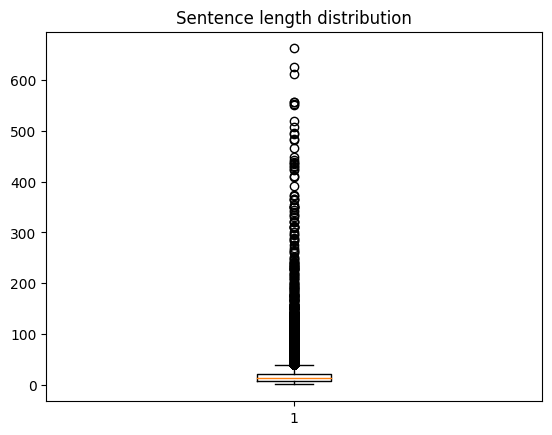

In [83]:
plt.boxplot(x=df['sents_length'])
plt.title('Sentence length distribution')
plt.savefig('Sentence-len-all.png');

### Further Inspection of Long Sentences

In [21]:
df[df['sents_length'] > 70]

In [27]:
de = df['sents_length'][df['lang'] == 'de']
en = df['sents_length'][df['lang'] == 'en']

In [28]:
no_music = df[~df['seg'].str.contains('music|musik|audio|♫|♪', regex=True, case=False)] #removed song lyrics

In [29]:
no_music_de = no_music['sents_length'][no_music['lang'] == 'de']
no_music_en = no_music['sents_length'][no_music['lang'] == 'en']

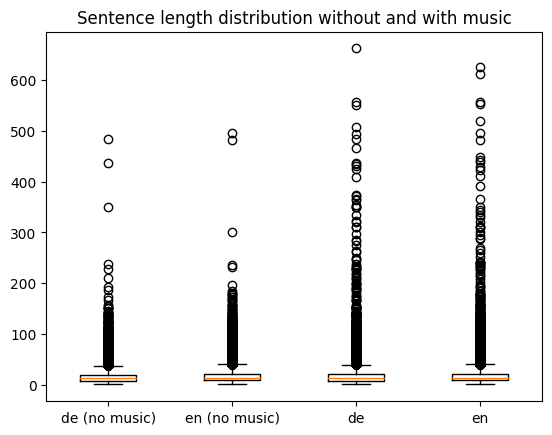

In [82]:
plt.boxplot(x=[no_music_de, no_music_en, de, en], labels=['de (no music)', 'en (no music)', 'de', 'en'])
plt.title('Sentence length distribution without and with music')
plt.savefig('Sentence-len-music.png');

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


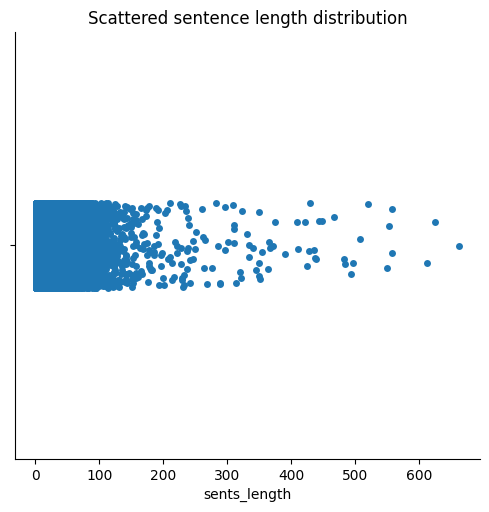

In [80]:
sns.catplot(x=df['sents_length'])
plt.title('Scattered sentence length distribution')
plt.savefig('Sentence-len-scatter.png');

## Further Pre-processing

In [35]:
stopwords = nltk.corpus.stopwords.words("english", "german")

Start of Filter for gendered words.  The frame's texts will be tokenized first.
Afterwards a list of Filter Words is initialized. The follwing function "wordfilter" will keep only rows with the Filterwords.
Afterwards the "get_pairs"-function only keeps those filtered rows that also have their translation in the frame.
The resulting dataframe contains the filtered rows for those cases, where the translation is not lost in the filtering.

In [36]:
# function takes a text-column  of a frame and then a list of filter Words as an argument and returns a Dataframe that only contains the rows that have the filter words in them.
# the column with tokenized text MUST be named "tokenized_no_punct"

def wordfilter(frame, keep):
    keep_rows = []
    for index, words in enumerate(frame["tokenized_no_punct"]):
        for i in words:
            if i in keep:
                keep_rows.append(index)
    return frame.loc[frame.index.isin(list(keep_rows))]

In [37]:
# applying the function to frame, giving the 2 arguments "frame" for dataframe and "keep" for the Filterwords
keep_words = ["Mann","man","Frau","woman", "wife", "husband", "Ehemann", "Ehefrau", "Anwalt", "Anwältin", "lawyer", "mother", "Mutter", "Vater", "father",
              "Junge", "boy", "Mädchen", "girl", "Arzt", "Ärztin", "doctor", "male", "female", "he", "she", "er", "sie"]
#df_filt = wordfilter(df_test, keep_words)
df_filt = wordfilter(df, keep_words)

In [38]:
# the following function will get the pairs of all the filtered rows based on the old index names
# it will also sort them and return a tidy frame

def get_pairs(frame):
    pair_exists = []
    evens = [0]
    for count, number in enumerate(frame.index):
        if number != frame.iloc[-1].name:
            if number + 1 ==  frame.iloc[count + 1].name:
                pair_exists.append(frame.iloc[count].name)
        else:
            break
    for i in list(pair_exists):
        if (i % 2) == 0:
            evens.append(i)
    new_df = frame.loc[frame.index.isin(evens)]
    new_df = pd.concat([new_df, (frame.loc[frame.index.isin(list(np.add(evens, 1)))])], axis = 0)
    new_df.sort_index(inplace = True, ascending = True, axis  = 0)
    return new_df

In [39]:
# applying function with DataFrame as argument
df_filt_pairs = get_pairs(df_filt)
df_filt_pairs

,lang,seg,tokenized_sents,tokenized_no_punct,sents_length
42,de,"Sie nahm unsere Bestellung auf, ging dann zum Paar in der Nische neben uns und senkte ihre Stimme so sehr, dass ich mich richtig anstrengen musste, um sie zu verstehen.","[Sie, nahm, unsere, Bestellung, auf, ,, ging, dann, zum, Paar, in, der, Nische, neben, uns, und, senkte, ihre, Stimme, so, sehr, ,, dass, ich, mich, richtig, anstrengen, musste, ,, um, sie, zu, verstehen, .]","[Sie, nahm, unsere, Bestellung, auf, ging, dann, zum, Paar, in, der, Nische, neben, uns, und, senkte, ihre, Stimme, so, sehr, dass, ich, mich, richtig, anstrengen, musste, um, sie, zu, verstehen]",30
43,en,"(Laughter) She took our order, and then went to the couple in the booth next to us, and she lowered her voice so much, I had to really strain to hear what she was saying.","[(, Laughter, ), She, took, our, order, ,, and, then, went, to, the, couple, in, the, booth, next, to, us, ,, and, she, lowered, her, voice, so, much, ,, I, had, to, really, strain, to, hear, what, she, was, saying, .]","[Laughter, She, took, our, order, and, then, went, to, the, couple, in, the, booth, next, to, us, and, she, lowered, her, voice, so, much, I, had, to, really, strain, to, hear, what, she, was, saying]",35
44,de,"Sie sagte: ""Ja, das ist Ex-Vizepräsident Al Gore und seine Frau Tipper.""","[Sie, sagte, :, ``, Ja, ,, das, ist, Ex-Vizepräsident, Al, Gore, und, seine, Frau, Tipper, ., '']","[Sie, sagte, Ja, das, ist, ExVizepräsident, Al, Gore, und, seine, Frau, Tipper]",12
45,en,"And she said ""Yes, that's former Vice President Al Gore and his wife, Tipper.""","[And, she, said, ``, Yes, ,, that, 's, former, Vice, President, Al, Gore, and, his, wife, ,, Tipper, ., '']","[And, she, said, Yes, thats, former, Vice, President, Al, Gore, and, his, wife, Tipper]",14
46,de,"Und der Mann antwortete: ""Ganz schöner Abstieg, was?""","[Und, der, Mann, antwortete, :, ``, Ganz, schöner, Abstieg, ,, was, ?, '']","[Und, der, Mann, antwortete, Ganz, schöner, Abstieg, was]",8
...,...,...,...,...,...
578483,en,"That's when I walk into the room to find Greta in a rage, shouting, ""That's not fair!""","[That, 's, when, I, walk, into, the, room, to, find, Greta, in, a, rage, ,, shouting, ,, ``, That, 's, not, fair, !, '']","[Thats, when, I, walk, into, the, room, to, find, Greta, in, a, rage, shouting, Thats, not, fair]",17
578554,de,Ich machte mir Sorgen um ihn ...,"[Ich, machte, mir, Sorgen, um, ihn, ...]","[Ich, machte, mir, Sorgen, um, ihn, ]",7
578555,en,I was nervous for him ...,"[I, was, nervous, for, him, ...]","[I, was, nervous, for, him, ]",6
578598,de,"Da war der Leiter der Personalabteilung, der vorschlug, dass ich eine Leitungsposition intern besetzte.","[Da, war, der, Leiter, der, Personalabteilung, ,, der, vorschlug, ,, dass, ich, eine, Leitungsposition, intern, besetzte, .]","[Da, war, der, Leiter, der, Personalabteilung, der, vorschlug, dass, ich, eine, Leitungsposition, intern, besetzte]",14


## Sentiment Analysis with NLTK (non-filtered)

In [40]:
#This one takes approx. 1 minute to load
# Initialize stemmers
snow_en = SnowballStemmer(language='english')
snow_de = SnowballStemmer(language='german')

# Define function to apply appropriate stemmer based on language
def stem_words(lang, word_list):
    if lang == 'en':
        stemmed_words = [snow_en.stem(word) for word in word_list]
    elif lang == 'de':
        stemmed_words = [snow_de.stem(word) for word in word_list]
    else:
        stemmed_words = word_list
    return stemmed_words

# Apply stemming function to appropriate rows based on language
df['stemmed'] = df.apply(lambda row: stem_words(row['lang'], row['tokenized_no_punct']), axis=1)

In [42]:
# Convert lists to strings
df['text_str'] = df['stemmed'].str.join(' ')

In [ ]:
#Initialize analyzers
analyzer_en = SentimentIntensityAnalyzer()
analyzer_de = SentimentModel()

In [ ]:
# Function to apply sentiment analysis based on language
def get_sentiment(row):
    text = row['text_str']
    lang = row['lang']
    try:
      if lang == 'en':
          prob = analyzer_en.polarity_scores(text)
          prob = prob['compound']
          if prob >= 0.05:
            sent = 'positive'
          elif prob <= -0.05:
            sent = 'negative'
          else:
            sent = 'neutral'
          return {sent : prob}
      elif lang == 'de':
          sent, prob = analyzer_de.predict_sentiment(text, output_probabilities=True)

          highest = max(prob[1][0][1], prob[1][1][1], prob[1][2][1], key=abs)
          if sent[0] == 'negative':
            highest = -highest

          return {sent[0] : highest}
      else:
          return None  # Handle other languages if needed
    except Exception as e:
        print(f"Error analyzing sentiment for text: {text}. Error: {e}") #We ignore these
        return None

In [ ]:
# Apply sentiment analysis function to each row
df['Sentiments_v2'] = df.apply(get_sentiment, axis=1)

In [49]:
# Function to extract the value from the dictionary
def get_dict_value(dictionary):
    if isinstance(dictionary, dict):
        return next(iter(dictionary.values()))
    else:
        return None

In [ ]:
# Apply the function to create the new column
df['sent_num'] = df['Sentiments_v2'].apply(get_dict_value)

In [51]:
# Function to extract the key from the dictionary
def get_dict_key(dictionary):
    if isinstance(dictionary, dict):
        return next(iter(dictionary.keys()))
    else:
        return None

# Apply the function to create the new column
df['sent_word'] = df['Sentiments_v2'].apply(get_dict_key)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

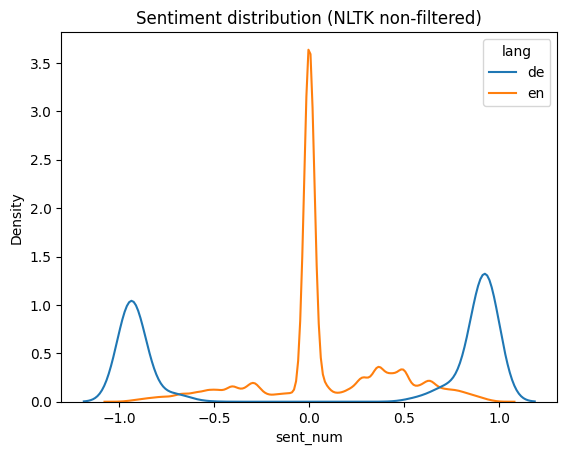

In [84]:
sns.kdeplot(data = df, x = 'sent_num', hue = 'lang')
plt.title("Sentiment distribution (NLTK non-filtered)")
plt.savefig('Sentiment-NLTK-Nonfilt.png');

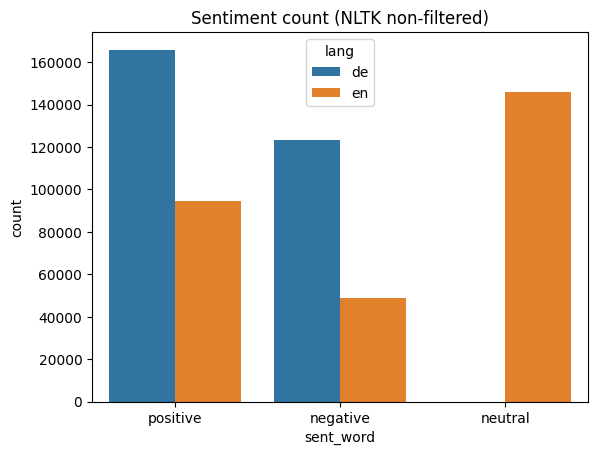

In [89]:
sns.countplot(data = df, x = 'sent_word', hue = 'lang')
plt.title("Sentiment count (NLTK non-filtered)")
plt.savefig('Sentiment-count-NLTK-Nonfilt.png');

## Sentiment Analysis with NLTK (filtered)

In [55]:
# Apply stemming function to appropriate rows based on language
df_filt_pairs['stemmed'] = df_filt_pairs.apply(lambda row: stem_words(row['lang'], row['tokenized_no_punct']), axis=1)

In [57]:
# Convert lists to strings
df_filt_pairs['text_str'] = df_filt_pairs['stemmed'].str.join(' ')

In [60]:
# Apply sentiment analysis function to each row
df_filt_pairs['Sentiments_v2'] = df_filt_pairs.apply(get_sentiment, axis=1)

Error analyzing sentiment for text: . Error: list index out of range


In [64]:
# Apply the dict value function to create the new column
df_filt_pairs['sent_num'] = df_filt_pairs['Sentiments_v2'].apply(get_dict_value)

In [65]:
# Apply the dict key function to create the new column
df_filt_pairs['sent_word'] = df_filt_pairs['Sentiments_v2'].apply(get_dict_key)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

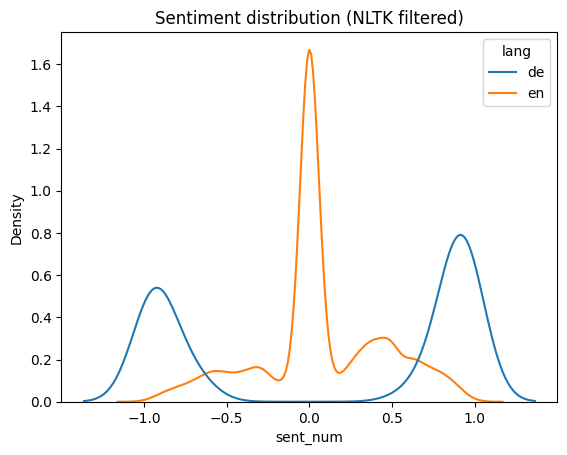

In [86]:
sns.kdeplot(data = df_filt_pairs, x = 'sent_num', hue = 'lang')
plt.title("Sentiment distribution (NLTK filtered)")
plt.savefig('Sentiment-NLTK-Filt.png');

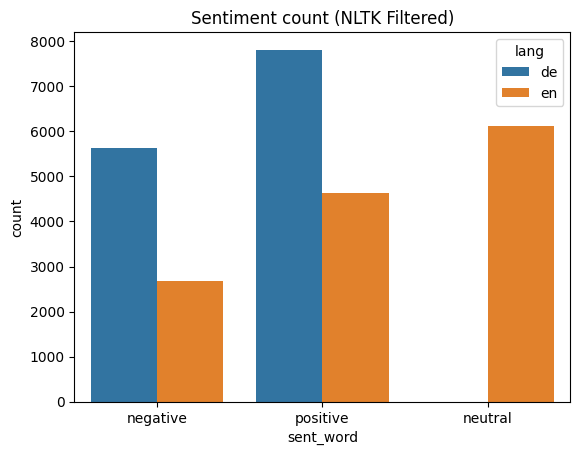

In [88]:
sns.countplot(data = df_filt_pairs, x = 'sent_word', hue = 'lang')
plt.title("Sentiment count (NLTK Filtered)")
plt.savefig('Sentiment-count-NLTK-Filt.png');

## Sentiment Analysis using BERT (with filtered dataset)

In [75]:
# Start of Transformers / Hugging Face Sentiment Analysis
# instantiating tokenizer

tokenizer_de = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [76]:
#defining function create a sentiment score based on a text segment

def sentiment_score(seg):
    tokens = tokenizer.encode(seg, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [79]:
#applying sentiment analysis to each text segment and collecting the scores in a new column

df_filt_pairs['sentiment'] = df_filt_pairs["seg"].apply(lambda x: sentiment_score(x[:512]))

In [90]:
# mean of the sentiments based on language

print("Average sentiment for English:", df_filt_pairs.loc[df_filt_pairs["lang"] == "en"].sentiment.mean().round(2))
print("Average sentiment for German:", df_filt_pairs.loc[df_filt_pairs["lang"] == "de"].sentiment.mean().round(2))

Average sentiment for English: 3.08
Average sentiment for German: 3.37


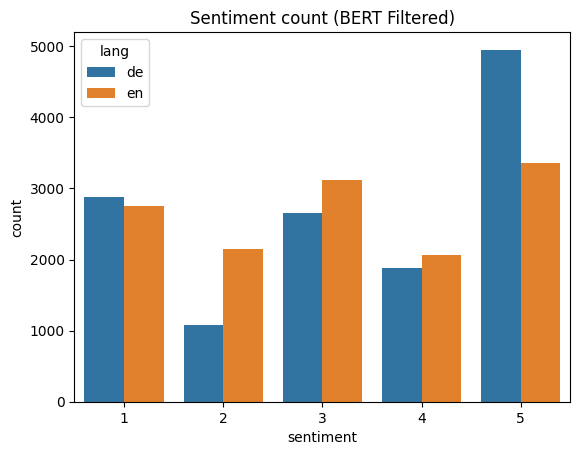

In [91]:
# Visualization of sentiment distribution based on language
sns.countplot(data = df_filt_pairs, x = "sentiment", hue = "lang")
plt.title("Sentiment count (BERT Filtered)")
plt.savefig('Sentiment-count-BERT-Filt.png');

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

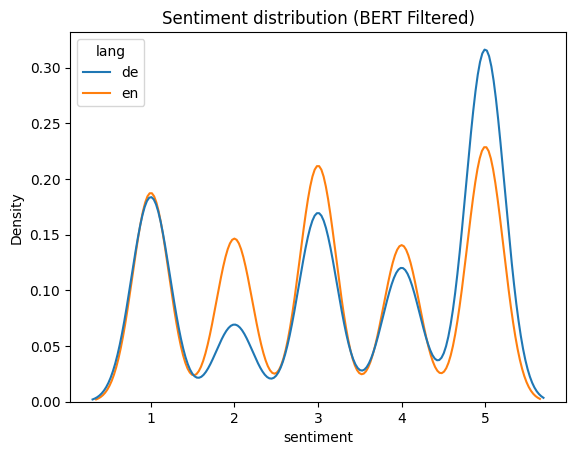

In [92]:
sns.kdeplot(data = df_filt_pairs, x = "sentiment", hue = "lang")
plt.title("Sentiment distribution (BERT Filtered)")
plt.savefig('Sentiment-BERT-Filt.png');

In [93]:
# Defining a function that takes a DataFrame with a column names "sentiment" (NECESSARY)
# Calculates the Difference is sentiment from the German original and the English translation
# Returns the Difference-Values in an Array

def SentimentDifference(Frame):
    sentiment_difference = []
    for count, i in enumerate(Frame.sentiment):
        if Frame.iloc[count].name % 2 == 1:
            diff = Frame.iloc[count]["sentiment"] - Frame.iloc[count - 1]["sentiment"]
            sentiment_difference.append(diff)
        elif Frame.iloc[count].name % 2 == 0:
            diff = Frame.iloc[count]["sentiment"] - Frame.iloc[count + 1]["sentiment"]
            sentiment_difference.append(diff)
    sentiment_difference = np.array(sentiment_difference)
    return sentiment_difference

In [94]:
# Applying the Difference-Function on the df_filt_pairs Frame
sentiment_difference = SentimentDifference(df_filt_pairs)
# Adding the Array as a column to the DataFrame
df_filt_pairs["sent_diff"] = sentiment_difference

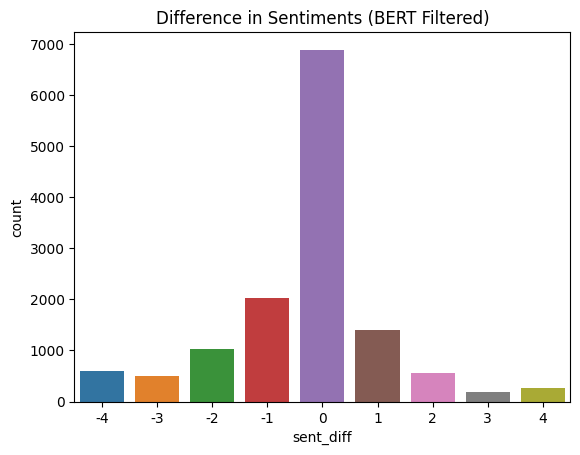

In [95]:
# Visualisation of the sentiment difference on the English translations
"""
Take note that the differences get mirrored when not differentiating between the languages.
E.g. every +1 in English Corresponds with a -1 for the German.
"""

df_filt_pairs_en = df_filt_pairs.loc[df_filt_pairs["lang"] == "en"]
sns.countplot(data = df_filt_pairs_en, x = "sent_diff")
plt.title("Difference in Sentiments (BERT Filtered)")
plt.savefig('Sentiment-BERT-difference-Filt.png');


## Sentiment Analysis using BERT (with non-filtered dataset)

In [ ]:
#applying sentiment analysis for a new column
df['sentiment'] = df["seg"].apply(lambda x: sentiment_score(x[:512]))

In [ ]:
# mean of the sentiments based on language
print("Average sentiment for English:", df.loc[df["lang"] == "en"].sentiment.mean().round(2))
print("Average sentiment for German:", df.loc[df["lang"] == "de"].sentiment.mean().round(2))

In [ ]:
# Visualization of sentiment distribution based on language
sns.countplot(data = df, x = "sentiment", hue = "lang")
plt.title("Sentiment count (BERT non-filtered)")
plt.savefig('Sentiment-count-BERT-Nonfilt.png');

In [ ]:
sns.kdeplot(data = df, x = "sentiment", hue = "lang")
plt.title("Sentiment distribution (BERT non-filtered)")
plt.savefig('Sentiment-BERT-Nonfilt.png');

# Attempt of Predictive Models

First try is a GradientBoostClassifier on the count-vectorized textsegments.

A Second attempt to predict sentiment-shifts in translations will be made with a simplpe Keras dense NN.

In [ ]:
# Already did this before, but we recall the filtered BERT dataset for the English texts

df_filt_pairs_en = df_filt_pairs.loc[df_filt_pairs["lang"] == "en"]


In [ ]:
# Setting up the explanatory and target variable, vectorizing the text and performing train-test-split

data = df_filt_pairs_en["seg"]
target = df_filt_pairs_en["sent_diff"]

vectorizer = CountVectorizer()
data = vectorizer.fit_transform(data).todense()

x_train, x_test, y_train, y_test = train_test_split(data, target, random_state = 123, test_size = 0.2)

In [ ]:
# setting up a simple GradientBoostingClassifier, fitting it with train-data and predicting on test-data

classifier = GradientBoostingClassifier(
    n_estimators = 50,
    learning_rate = 1,
    max_depth = 3,
    random_state = 123
)

classifier.fit(x_train_array, y_train)
y_pred = classifier.predict(x_test_array)

In [ ]:
# setting up a DataFrame with the results for easy comparison

results = pd.DataFrame({'prediction': y_pred})
results["y_test"] = y_test.values
pred_count = results.prediction.value_counts()
test_count = results.y_test.value_counts()

comparison = pd.DataFrame({"pred_counts" : pred_count, "test_count" : test_count})
comparison

In [ ]:
# small heatmap of the results. not really promising

cfm = pd.crosstab(y_test, y_pred)
sns.heatmap(cfm)
plt.title("Prediction of sentiment shifts")
plt.savefig('Sentiment-shifts-prediction.png')

In [ ]:
print(classification_report(y_test, y_pred))


In [ ]:
# ATTEMPTING A PREDICTION WITH A dense NN.

# defining layers
inputs = Input(shape = (18566), name = "Inputs")
dense1 = Dense(units = 200, activation = "relu")
dropout1 = Dropout(0.2)
dense2 = Dense(units = 100, activation = "relu")
dropout2 = Dropout(0.2)
dense3 = Dense(units = 9, activation = "softmax") # 9 classes for sentiment difference -4 to 4 in steps of 1

# connecting layers
x = dense1(inputs)
x = dropout1(x)
x = dense2(x)
x = dropout2(x)
outputs = dense3(x)

# instantiating model
model = Model(inputs = inputs, outputs = outputs)

In [ ]:
# creating a binary, categorical set of target variables

y_train_cat = to_categorical(y_train, 9)
y_test_cat = to_categorical(y_test, 9)

In [ ]:
# instantiating callback for the DNN

from tensorflow.keras.callbacks import ReduceLROnPlateau

RLRP = ReduceLROnPlateau(monitor = "accuracy",
                         optimizer = "adam",
                         mode = "max",
                         cooldown = 2,
                         patience = 2,
                         )

In [ ]:
# compiling, fitting and predicting with the DNN

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

history = model.fit(x_train, y_train_cat, epochs = 6, validation_split = 0.25, callbacks = RLRP)

model_pred = model.predict(x_test)

In [ ]:
# transforming the predictions into the metrics from -4 to 4 in steps of 1 (9 classes)

model_pred_class = model_pred.argmax(axis = 1)

model_pred_class[model_pred_class == 0] = -4
model_pred_class[model_pred_class == 1] = -3
model_pred_class[model_pred_class == 2] = -2
model_pred_class[model_pred_class == 3] = -1
model_pred_class[model_pred_class == 4] = 0
model_pred_class[model_pred_class == 5] = 1
model_pred_class[model_pred_class == 6] = 2
model_pred_class[model_pred_class == 7] = 3
model_pred_class[model_pred_class == 8] = 4

np.unique(model_pred_class)


In [ ]:
# first glance evaluation of the data

print(classification_report(y_test, model_pred_class))

cfm = confusion_matrix(y_test, model_pred_class)
print(pd.crosstab(y_test.values, model_pred_class))


# BERT Version 2: Faster

## Imports

In [ ]:
from typing import Optional
from pathlib import Path
import requests
import gzip
import pandas as pd
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    PreTrainedTokenizer, 
    PreTrainedModel
)

import torch

from tqdm import tqdm 
tqdm.pandas()

## Global

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CORPUS_URL: str = 'https://object.pouta.csc.fi/OPUS-TED2020/v1/tmx/de-en.tmx.gz'
DATA_PATH: Path = Path('data')

CORPUS_RAW_PATH: Path = Path.joinpath(DATA_PATH, 'de-en.tmx')
CORPUS_PATH: Path = Path.joinpath(DATA_PATH, 'de-en.json')
    
CORPUS_DE_PATH: Path = Path.joinpath(DATA_PATH, 'de.json')
CORPUS_EN_PATH: Path = Path.joinpath(DATA_PATH, 'en.json')
    
CORPUS_DE_EN_PATH: Path = Path.joinpath(DATA_PATH, 'de_en_sentiment.json')

## Utils

In [ ]:
def download_file(
    url: str, 
    *,
    force: bool = False
) -> Path: 
    file_name: str = url.split('/')[-1]
    file_path: Path = Path.joinpath(DATA_PATH, file_name)
    
    if file_path.exists() and not force: 
        return file_path
    
    try:
        response: requests.Response = requests.get(url, stream=True)
        
        with file_path.open('wb') as file: 
            file.write(response.content)
            return file_path
    except Exception as e: 
        raise ValueError(f'An error occured: {e}')

In [ ]:
def unzip_file(
    file_path_in: Path,
    *,
    file_path_out: Optional[Path] = None,
    remove_gz: bool = False
) -> Path:
    if file_path_in.suffix != '.gz':
        raise ValueError(f'File Path {file_path_in} is not a ".gz" file')

    if not file_path_out:
        file_path_out = file_path_in.with_suffix('') 

    with gzip.open(file_path_in, 'rb') as file_in:
        with open(file_path_out, 'wb') as file_out:
            file_out.write(file_in.read())

    if remove_gz:
        file_path_in.unlink()

    return file_path_out

In [ ]:
def hgf_sentiment_analyser(
    inputs: list[str],
    *,
    device: str,
    tokenizer: PreTrainedTokenizer, 
    model: PreTrainedModel, 
) -> list[list[float]]:
    model.to(device)

    inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        logits = model(**inputs).logits

    probabilities = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

    return probabilities.tolist()

In [ ]:
def hgf_sentiment_analyser_batch(
    inputs: list[str],
    *,
    batch_size: int,
    device: str,
    tokenizer: PreTrainedTokenizer,
    model: PreTrainedModel,
) -> list[list[float]]:
    all_probabilities = []

    for i in tqdm(range(0, len(inputs), batch_size), desc="Processing batches"):
        batch_inputs = inputs[i:i + batch_size]

        batch_probabilities = hgf_sentiment_analyser(
            inputs=batch_inputs,
            device=device,
            tokenizer=tokenizer,
            model=model
        )

        all_probabilities.extend(batch_probabilities)
    
    return all_probabilities

## Download Data

In [ ]:
# Download Data
if not DATA_PATH.exists(): 
    DATA_PATH.mkdir()

CORPUS_FILE_PATH: Path = download_file(CORPUS_URL)
CORPUS_FILE_PATH: str = unzip_file(CORPUS_FILE_PATH)

## XML to JSON

In [ ]:
CORPUS_DF: pd.DataFrame = pd.read_xml(CORPUS_RAW_PATH, xpath="//tuv[@xml:lang]")
CORPUS_DF = CORPUS_DF.rename(columns={'seg': 'text'})
CORPUS_DF.dropna(inplace=True)

CORPUS_DF.to_json(CORPUS_PATH, orient='records', indent=4)

## Data

In [ ]:
CORPUS_DF: pd.DataFrame = pd.read_json(CORPUS_PATH)
CORPUS_DE_S: pd.Series = CORPUS_DF[CORPUS_DF['lang'].str.contains('de')]['text']
CORPUS_EN_S: pd.Series = CORPUS_DF[CORPUS_DF['lang'].str.contains('en')]['text']
pd.DataFrame(CORPUS_DE_S).to_json(CORPUS_DE_PATH, orient='records', indent=4)
pd.DataFrame(CORPUS_EN_S).to_json(CORPUS_EN_PATH, orient='records', indent=4)

## Sentiment Analysis (Inference)

In [ ]:
CORPUS_DE_DF: pd.DataFrame = pd.read_json(CORPUS_DE_PATH)
CORPUS_EN_DF: pd.DataFrame = pd.read_json(CORPUS_EN_PATH)

In [ ]:
# https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
TOKENIZER = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment") # TODO correct typing
MODEL = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment") # TODO correct typing
SENTIMENT_COLUMNS = ['-2', '-1', '0', '1', '2']
de_sentiments_df: pd.DataFrame = pd.DataFrame(
    hgf_sentiment_analyser_batch(
        CORPUS_DE_DF['text'].tolist(),
        batch_size=50,
        device=DEVICE,
        tokenizer=TOKENIZER,
        model=MODEL
    ),
    columns=SENTIMENT_COLUMNS
)

In [ ]:
de_sentiments_df = de_sentiments_df.reset_index(drop=True)
CORPUS_DE_DF = CORPUS_DE_DF.reset_index(drop=True)

CORPUS_DE_DF: pd.DataFrame = pd.concat([CORPUS_DE_DF, de_sentiments_df], axis=1)

CORPUS_DE_DF.to_json(CORPUS_DE_PATH, orient='records', indent=4)

In [ ]:
en_sentiments_df: pd.DataFrame = pd.DataFrame(
    hgf_sentiment_analyser_batch(
        CORPUS_EN_DF['text'].tolist(),
        batch_size=50,
        device=DEVICE,
        tokenizer=TOKENIZER,
        model=MODEL
    ),
    columns=SENTIMENT_COLUMNS
)

In [ ]:
en_sentiments_df = en_sentiments_df.reset_index(drop=True)
CORPUS_EN_DF = CORPUS_EN_DF.reset_index(drop=True)

CORPUS_EN_DF: pd.DataFrame = pd.concat([CORPUS_EN_DF, en_sentiments_df], axis=1)
    
CORPUS_EN_DF.to_json(CORPUS_EN_PATH, orient='records', indent=4)

## Sentiment Difference


In [ ]:
CORPUS_DE_DF: pd.DataFrame = pd.read_json(CORPUS_DE_PATH)
CORPUS_DE_DF = CORPUS_DE_DF.rename(columns={'text':'german', '-2': 'de_-2', '-1':'de_-1', '0':'de_0', '1':'de_1', '2':'de_2'})

CORPUS_EN_DF: pd.DataFrame = pd.read_json(CORPUS_EN_PATH)
CORPUS_EN_DF = CORPUS_EN_DF.rename(columns={'text':'english', '-2': 'en_-2', 'en_-1':'en_-1', '0':'en_0', '1':'en_1', '2':'en_2'})

CORPUS_DE_EN_DF: pd.DataFrame = pd.concat([CORPUS_DE_DF, CORPUS_EN_DF], axis=1)
CORPUS_DE_EN_DF['de_sentiment'] = CORPUS_DE_EN_DF.filter(like='de_').idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))
CORPUS_DE_EN_DF['en_sentiment'] = CORPUS_DE_EN_DF.filter(like='en_').idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))
CORPUS_DE_EN_DF['sentiment_diff'] = abs(CORPUS_DE_EN_DF['de_sentiment'] - CORPUS_DE_EN_DF['en_sentiment'])
CORPUS_DE_EN_DF.to_json(CORPUS_DE_EN_PATH, orient='records', indent=4)


### Find and Filter Gender Words

In [ ]:
male_words_en = "man|husband|father|boy|male|he|"
female_words_en = "woman|wife|mother|girl|female|she"

male_words_de = "Mann|Ehemann|Vater|Junge|er|männlich"
female_words_de = "Frau|Ehefrau|Mutter|Mädchen|sie|weiblich"
df_male_en = df[df['english'].str.contains(male_words_en)]
df_male_de = df[df['english'].str.contains(male_words_en)]

df_female_en = df[df['english'].str.contains(female_words_en)]
df_female_de = df[df['english'].str.contains(female_words_de)]

In [ ]:
filtered_df_en = df[df['english'].str.contains(english_words_concatenated)]
filtered_df_en_de = filtered_df_en[filtered_df_en['german'].str.contains(german_words_concatenated)]
filtered_df_en_de.head()

## Viz

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load JSON data
with open('de_en_sentiment.json') as f:
    data = json.load(f)
df = pd.read_json(data)
df.head()

In [ ]:
sns.kdeplot(data = df, x = "de_sentiment", color = "steelblue", label="de_all")
sns.kdeplot(data = df, x = "en_sentiment", color = "darkorange", label="en_all")
plt.legend()
plt.title("Sentiment Distribution No Filter")
plt.savefig('SentDistNoFilt.png');

In [ ]:
sns.kdeplot(data = df_male_en, x = "en_sentiment", color = "sandybrown", label="en_male", linestyle=':')
sns.kdeplot(data = df_female_en, x = "en_sentiment", color = "peru", label="en_female", linestyle='dashdot')
plt.legend()
plt.title('Sentiment distribution male vs. female (EN)')
plt.savefig('SentDistMF-EN.png')
plt.show();

In [ ]:
sns.kdeplot(data = df_male_de, x = "de_sentiment", color = "skyblue", label="de_male", linestyle=':')
sns.kdeplot(data = df_female_de, x = "de_sentiment", color = "darkblue", label="de_female", linestyle='dashdot')
plt.legend()
plt.title('Sentiment distribution male vs. female (DE)')
plt.savefig('SentDistMF-DE.png')
plt.show();

In [ ]:
sns.kdeplot(data = filtered_df_en_de, x = "de_sentiment", color = "steelblue", label="de_gen", linestyle='--')
sns.kdeplot(data = filtered_df_en_de, x = "en_sentiment", color = "darkorange", label="en_gen", linestyle='--')
plt.legend()
plt.title("Sentiment Distribution with Gendered Words")
plt.savefig('SentDistGendered.png');

In [ ]:
sns.kdeplot(data = df, x = "de_sentiment", color = "steelblue", label="de_all")
sns.kdeplot(data = filtered_df_en_de, x = "de_sentiment", color = "steelblue", label="de_gen", linestyle='--')
plt.title("Sentiment Distribution with and without Gendered Words (DE)")
plt.legend()
plt.savefig('SentDistGenNoGen-DE.png')
plt.show();

In [ ]:
sns.kdeplot(data = df, x = "en_sentiment", color = "darkorange", label="en_all")
sns.kdeplot(data = filtered_df_en_de, x = "en_sentiment", color = "darkorange", label="en_gen", linestyle='--')
plt.legend()
plt.title("Sentiment Distribution with and without Gendered Words (EN)")
plt.savefig('SentDistGenNoGen-EN.png');